In [1]:
######################################### Get file & load into json #########################################
import json
import pandas as pd
import requests
import json
from datetime import date
from datetime import datetime, timedelta
# from pandas.io.json import json_normalize
# from flatten_json import flatten
import shutil


url_API = "https://api.battlepeer.com/organizations/api-key/organizations?apiKey=pF57WF2rmnDkoayOXdtLYTFYRM"
response_API = requests.get(url_API)
# print(response_API.status_code)

data = response_API.text
parse_json = json.loads(data)
# print("Survey: ", parse_json)

yFile = json.dumps(parse_json, indent=4)
print(yFile)


[
    {
        "id": 3,
        "name": "Great Lakes Dryhootch",
        "address": "1030 E Brady St, Milwaukee, WI 53202",
        "users": [
            {
                "id": 43,
                "initials": "Z.F.",
                "checkIn": [
                    {
                        "date": "2023-06-24T20:32:09.108Z",
                        "max_score": 15,
                        "score": 13,
                        "ratio": 0.87,
                        "ratioDisplayName": "good"
                    }
                ]
            },
            {
                "id": 45,
                "initials": "M.L.",
                "checkIn": [
                    {
                        "date": "2023-01-23T17:48:02.183Z",
                        "max_score": 15,
                        "score": 11,
                        "ratio": 0.73,
                        "ratioDisplayName": "normal"
                    },
                    {
                        "date": "2023-01-24T

In [2]:
##################################### Get json written into a excel file, add the name Survey #####################################

from datetime import date
import os

today_date = date.today()
print(today_date)
# mypath_short = "C:/Users/lucyle/Desktop/BattlePeer_json/" + str(today_date) + "/"
## for EC2
# temp_path = "/home/ec2-user/BattlePeer_Data"
temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
mypath_short = temp_path + "/" + str(today_date) + "/"

# Check if folder exists, if so, delete and remake folder
if os.path.exists(mypath_short):
    shutil.rmtree(mypath_short, ignore_errors=True)

os.mkdir(mypath_short)

my_string =  "iPeer_API_" + str(today_date) + ".json"
mypath = mypath_short + my_string
print(mypath)

# write the text data to json file
with open(mypath, 'w') as f:
    f.writelines("{ \"CheckIns\": ") # name of json data
    f.writelines(yFile)
    f.writelines("}")    


2023-11-10
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/iPeer_API_2023-11-10.json


In [3]:
##################################### explore json file and normalize it ##################################### 
# !pip3 install openpyxl

# load text data 
with open(mypath) as f:
    d = json.load(f)
    # print(d)

# normalize and flatten file/data frame
df = pd.json_normalize(d, record_path =['CheckIns'])
print("size: ",df.shape)

df = df.explode('users')
df = pd.json_normalize(json.loads(df.to_json(orient="records")))
newpath = mypath_short + str(today_date) + "_df.xlsx"
df.to_excel(newpath)

# print(df)

size:  (12, 4)


In [4]:
######################################### explode users more with details #########################################

df = df.explode('users.checkIn')
df = pd.json_normalize(json.loads(df.to_json(orient="records")))
# df2 = df.drop('users', axis=1) #drop column users
newpath = mypath_short + str(today_date) + "_df_users.xlsx"
# df.to_excel(newpath)
# print(df)


In [5]:
############################# get the date extracted from users.checkIn.dates #############################

# get index of column with date
index1 = -1
for col in df.columns:
    if "checkIn.date" in col:
        # print(col)
        index1 = df.columns.get_loc(col)
# print(index1)

# Check if successfully get the date column correctly
if index1 == -1:
    print("Failed to get index. Exit....!")
    sys.exit()

# Add the dates into a new column after extracting/splitting string 
dates_list = []
for date in df.iloc[:,index1]:
    mystr = str(date)
    if mystr == "":
        dates_list.append("nan")
    else:
        mystr = str(date).split("T")
        date = mystr[0]
        dates_list.append(date)
        
for i in range(0, len(dates_list)):
    if dates_list[i] == "None":
        dates_list[i] = "nan"

df["Short Date"] = dates_list

newpath = mypath_short + str(today_date) + "_df_dates.xlsx"
# df.to_excel(newpath)


# print("Total amount of rows from raw data", len(df))


In [6]:
############################# Get week numbers and add it into new column #############################
############################# Take only dates starting from 2023-1-1 #############################
from datetime import *

weeks_list = []

date_2023 = date(2023,1,1)

for date in df['Short Date']:
    if date != 'nan':
        date_object = datetime.strptime(date, '%Y-%m-%d').date()
        week_number = date_object.isocalendar()[1]

        if date_object < date_2023:
            # date_object = "nan"
            week_number = 0

        weeks_list.append(week_number)
    else:
        weeks_list.append("nan")
        
df["Week Number"] = weeks_list

newpath = mypath_short + str(today_date) + "_df_weeks.xlsx"

# df.to_excel(newpath)


In [7]:
# ############################# Drop rows with dates less than 2023-1-1 #############################

df2 = df[df["Week Number"] != 0]
newpath = mypath_short + str(today_date) + "_df_new.xlsx"
df2.to_excel(newpath)


In [8]:
############################ Get individual dataset for each mentee & put in excel ###################################
import math
mentors_list = df2["id"].unique()
# print("Mentors ID: ", mentors_list)
print("Mentor organizations count: ", len(mentors_list))

mentors_list = df2["name"].unique()
# print("Mentor Organizations: ", mentors_list)

df3 = pd.DataFrame
df3 = df2[df2["id"] == 3]
 
mentees_list = df3["users.id"].unique()   

print("Mentees count: ", mentees_list.shape[0])

list_menteedf = []
# print(mypath_short) 
newfile = mypath_short + "Mentees/"
if os.path.exists(newfile):
    shutil.rmtree(newfile, ignore_errors=True)
    
# print(newfile)
os.mkdir(newfile)

for id in mentees_list:
    df_mentee = pd.DataFrame
    df_mentee = df3[df3["users.id"] == id]
    list_menteedf.append(df_mentee)
    s_name = newfile + str(id).replace(".0", "") + ".xlsx"
    # print(s_name)
    df_mentee.to_excel(s_name) 


print("Total amount of rows from raw data", len(df))
print("Total amount of rows from raw data from Dryhootch 3", len(df3))


Mentor organizations count:  12
Mentees count:  121
Total amount of rows from raw data 1313
Total amount of rows from raw data from Dryhootch 3 1295


In [9]:
################################# Add all mentee files in dataframe #################################
import os
import openpyxl

print(mypath_short)
folder = mypath_short + "Mentees/"
print(folder)

dir_list = os.listdir(folder)
# print("Files and directories in '", folder, "' :")
# print(dir_list)

df_master = []
for file in dir_list:
    filename = folder + file 
    print(filename)
    df = pd.read_excel(filename)
    df_master.append(df)

# print(df_master[1])

/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/58.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/100.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/116.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/141.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/62.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/182.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees/74.xlsx
/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_

In [10]:
# Build date object list for all dates until today
# current_date = datetime.today()
datelist_2023 = pd.date_range(start="2023-01-01",end=today_date).tolist()
print(datelist_2023)

[Timestamp('2023-01-01 00:00:00'), Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-03 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-05 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-07 00:00:00'), Timestamp('2023-01-08 00:00:00'), Timestamp('2023-01-09 00:00:00'), Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-12 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-01-14 00:00:00'), Timestamp('2023-01-15 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-18 00:00:00'), Timestamp('2023-01-19 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-21 00:00:00'), Timestamp('2023-01-22 00:00:00'), Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-24 00:00:00'), Timestamp('2023-01-25 00:00:00'), Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-01-28 00:00:00'), Timestamp('2023-01-29 00:00:00'), Timestamp('20

In [11]:
########################################## ADD initial column MISS into each mentee's file ##########################################

# print(mypath_short)
folder = mypath_short + "Mentees/"

for dfmini in df_master:
    Miss_week_col = []
    for week in dfmini["Week Number"]:
        if week == "nan":
            Miss_week_col.append(week)
        else:
            Miss_week_col.append(False)
    dfmini["Miss"] = Miss_week_col
    filename = folder + str(dfmini["users.id"][0]) + ".xlsx"
    # print(filename)
    dfmini.to_excel(filename)


In [12]:
########################################## Compare and add missing dates into each mentee's dataframe ##########################################
# Build date objects list for all dates 
# current_date = datetime.today()
datelist_2023 = pd.date_range(start="2023-01-01",end=today_date).tolist()

total_days_2023 = datelist_2023.count

datelist_2023_fm = []
for date in datelist_2023:
    date_object = date.strftime('%Y-%m-%d')
    datelist_2023_fm.append(date_object)

print(len(datelist_2023_fm))


# mypath_short = "/Users/lucyl/Desktop/2022 PhD CompScience/iPeer Veterans w PTSD Research/BattlePeer json/" + str(today_date) + "/"
temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
# temp_path = "/home/ec2-user/BattlePeer_Data" ## for EC2
mypath_short = temp_path + "/" + str(today_date) + "/"


folder = mypath_short + "Mentees/"
# Check if folder exists, if so, delete and remake folder
if os.path.exists(folder):
    shutil.rmtree(folder, ignore_errors=True)
os.mkdir(folder)
print("Made folder")

dict_days = {}

for dfmini in df_master:
    print(dfmini["users.id"][0])
    count = 0
    dates_list2 = []
    for date in dfmini["Short Date"].tolist():
        print(date)
        if str(date) != "" and str(date) != "nan":
            date_object = datetime.strptime(date, '%Y-%m-%d').date()
            dates_list2.append(date_object)

    for date1 in datelist_2023_fm:
        print(date1)
        date_object = datetime.strptime(date1, '%Y-%m-%d').date()
        week_number = date_object.isocalendar()[1]

        if date_object in dates_list2:
            print("It's present")
            # miss = False
            count += 1
        else:
            print("It's missing")
            miss = True

            if date1 == "2023-01-01":
                week_number = 0
            
            # print(dfmini.columns)
            newrow = pd.DataFrame({"id":dfmini["id"][0], "name":dfmini["name"][0], \
                               "address":dfmini["address"][0], "users.id":dfmini["users.id"][0], \
                                "users.initials":dfmini["users.initials"][0], "Short Date":date1, \
                                    "Week Number":week_number, "Miss":miss}, index=[0])
            
            # dfmini = dfmini.append(newrow, ignore_index=True)
            dfmini = pd.concat([dfmini, newrow], ignore_index=True)
            # dfmini.loc[len(df)] = newrow
            # dfmini = dfmini.add(newrow)


    dfmini["Miss"] = dfmini["Miss"].replace([False, True], ["CheckedIn","Missed"])
    dfmini.sort_values("Short Date")
    filename = folder + str(dfmini["users.id"][0]) + ".xlsx"
    dfmini.to_excel(filename)
    
    dict_days[dfmini["users.id"][0]] = count


314
Made folder
58
2023-02-17
2023-03-02
2023-03-03
2023-03-06
2023-03-07
2023-03-08
2023-03-13
2023-03-17
2023-03-20
2023-03-23
2023-03-27
2023-04-08
2023-04-18
2023-04-25
2023-05-16
2023-06-08
2023-01-01
It's missing
2023-01-02
It's missing
2023-01-03
It's missing
2023-01-04
It's missing
2023-01-05
It's missing
2023-01-06
It's missing
2023-01-07
It's missing
2023-01-08
It's missing
2023-01-09
It's missing
2023-01-10
It's missing
2023-01-11
It's missing
2023-01-12
It's missing
2023-01-13
It's missing
2023-01-14
It's missing
2023-01-15
It's missing
2023-01-16
It's missing
2023-01-17
It's missing
2023-01-18
It's missing
2023-01-19
It's missing
2023-01-20
It's missing
2023-01-21
It's missing
2023-01-22
It's missing
2023-01-23
It's missing
2023-01-24
It's missing
2023-01-25
It's missing
2023-01-26
It's missing
2023-01-27
It's missing
2023-01-28
It's missing
2023-01-29
It's missing
2023-01-30
It's missing
2023-01-31
It's missing
2023-02-01
It's missing
2023-02-02
It's missing
2023-02-03
It

In [13]:
#### Check on total of days versus the amount of days for each mentee

print("Total days: ", len(datelist_2023))
print("Total mentees: ", len(dict_days))
print(dict_days)

Total days:  314
Total mentees:  121
{58: 16, 100: 8, 116: 0, 141: 0, 62: 19, 182: 0, 74: 10, 54: 21, 136: 0, 81: 62, 161: 0, 78: 6, 97: 0, 79: 3, 96: 4, 176: 5, 160: 0, 137: 0, 80: 36, 43: 1, 55: 8, 75: 11, 183: 8, 140: 0, 59: 11, 156: 0, 52: 34, 68: 4, 87: 1, 167: 7, 188: 13, 171: 0, 126: 35, 91: 1, 151: 1, 106: 1, 147: 0, 64: 2, 184: 8, 72: 15, 73: 12, 185: 2, 65: 5, 146: 0, 49: 2, 111: 12, 107: 16, 150: 0, 127: 0, 90: 14, 166: 0, 69: 9, 131: 6, 86: 13, 45: 21, 93: 3, 124: 0, 173: 7, 165: 0, 85: 2, 132: 15, 149: 0, 46: 94, 108: 0, 50: 0, 128: 0, 70: 135, 190: 1, 169: 0, 89: 63, 66: 13, 145: 5, 112: 62, 104: 7, 153: 0, 152: 0, 144: 0, 88: 0, 67: 29, 187: 0, 168: 0, 191: 0, 129: 0, 71: 10, 109: 3, 148: 0, 84: 1, 133: 3, 164: 0, 92: 0, 125: 26, 99: 6, 76: 0, 180: 0, 138: 16, 60: 12, 143: 19, 114: 0, 155: 0, 95: 10, 163: 0, 83: 104, 134: 21, 118: 8, 56: 19, 159: 0, 158: 0, 82: 8, 135: 4, 162: 0, 123: 0, 154: 0, 103: 2, 115: 8, 142: 0, 139: 0, 61: 41, 181: 0, 178: 15, 98: 5, 77: 8}


In [14]:
#### export dictionary of list_days into excel for analysis
import pandas as pd

df_days = pd.DataFrame
df_days = pd.DataFrame(data=dict_days, index=[0])
df_days = (df_days.T)
# print(df_days)

temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
# temp_path = "/home/ec2-user/BattlePeer_Data" ## for EC2
mypath_short = temp_path + "/" + str(today_date) + "/"
newpath = mypath_short + "dictionary.xlsx"

# change/add column names to dataframe
# df_days.columns = ["Mentee","Days_Count"]

df_days.to_excel(newpath)

df_days_1 = pd.read_excel(newpath)
df_days_1.columns = ["Mentee","Days_Count"]


df_days_1["Percentage"] = df_days_1["Days_Count"]/len(datelist_2023)
print(df_days_1)

df_days_1.to_excel(newpath)

     Mentee  Days_Count  Percentage
0        58          16    0.050955
1       100           8    0.025478
2       116           0    0.000000
3       141           0    0.000000
4        62          19    0.060510
..      ...         ...         ...
116      61          41    0.130573
117     181           0    0.000000
118     178          15    0.047771
119      98           5    0.015924
120      77           8    0.025478

[121 rows x 3 columns]


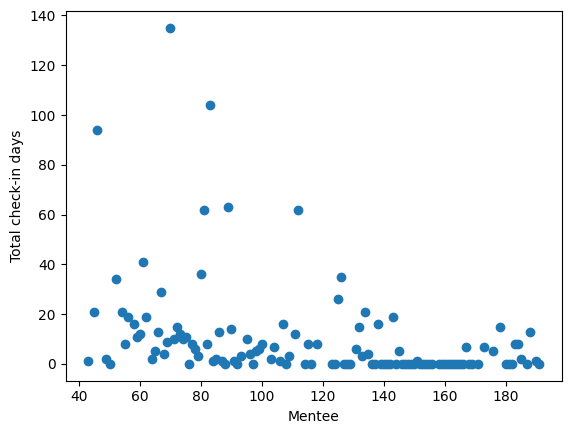

In [15]:
### Plot the dataframe
# !pip3 install matplotlib
import matplotlib.pyplot as plt 

x = df_days_1["Mentee"]
y = df_days_1["Days_Count"]

plt.scatter(x, y)
plt.xlabel("Mentee")
plt.ylabel("Total check-in days")

plt.show()

In [16]:
################## Re-read all files in folder Mentees_new ######################

# "C:\Users\lucyle\Desktop\BattlePeer_json\2023-06-25\Mentees_new"
# Build path
import datetime
import os
import pandas as pd

# today_string = str(datetime.date.today())
# print(today_string)
today_string = str(today_date)

# mentees_path = "C:\\Users\\lucyle\\Desktop\\BattlePeer_json"
# mentees_path = "/Users/lucyl/Desktop/2022 PhD CompScience/iPeer Veterans w PTSD Research/BattlePeer json/"
temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
mentees_path = temp_path + "/" + today_string + "/Mentees"

print(mentees_path)

# Get all files from folder
files_list = []
files_list = os.listdir(mentees_path)
print(files_list)

# read all files into big list of dataframes
df_master1 = []
for file in files_list:
    newpath = mentees_path + "/" + file
    df = pd.read_excel(newpath)
    df_master1.append(df)
    




/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees
['58.xlsx', '100.xlsx', '116.xlsx', '141.xlsx', '62.xlsx', '182.xlsx', '74.xlsx', '54.xlsx', '136.xlsx', '81.xlsx', '161.xlsx', '78.xlsx', '97.xlsx', '79.xlsx', '96.xlsx', '176.xlsx', '160.xlsx', '137.xlsx', '80.xlsx', '43.xlsx', '55.xlsx', '75.xlsx', '183.xlsx', '140.xlsx', '59.xlsx', '156.xlsx', '52.xlsx', '68.xlsx', '87.xlsx', '167.xlsx', '188.xlsx', '171.xlsx', '126.xlsx', '91.xlsx', '151.xlsx', '106.xlsx', '147.xlsx', '64.xlsx', '184.xlsx', '72.xlsx', '73.xlsx', '185.xlsx', '65.xlsx', '146.xlsx', '49.xlsx', '111.xlsx', '107.xlsx', '150.xlsx', '127.xlsx', '90.xlsx', '166.xlsx', '69.xlsx', '131.xlsx', '86.xlsx', '45.xlsx', '93.xlsx', '124.xlsx', '173.xlsx', '165.xlsx', '85.xlsx', '132.xlsx', '149.xlsx', '46.xlsx', '108.xlsx', '50.xlsx', '128.xlsx', '70.xlsx', '190.xlsx', '169.xlsx', '89.xlsx', '66.xlsx', '145.xlsx', '112.xlsx', '104.xlsx', '153.xlsx', '152.xlsx', '144.xlsx', '88.xlsx', '

In [17]:
# get all users.id mentee's id  into a list
users_id_list = []
for df in df_master1:
    users_id_list.append(df["users.id"][0])
users_id_list.sort()


In [18]:
# Check on counts of mentors and mentees
print("All mentees' IDs: " + str(users_id_list))
print("Total mentees: " + str(len(users_id_list)))

All mentees' IDs: [43, 45, 46, 49, 50, 52, 54, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 103, 104, 106, 107, 108, 109, 111, 112, 114, 115, 116, 118, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 173, 176, 178, 180, 181, 182, 183, 184, 185, 187, 188, 190, 191]
Total mentees: 121


In [19]:
    # ##### Test pivot table #######
    # pivot_df1 = find_df1(60)
    # # Create a new pivot table  #columns=["Miss","CheckIn","Missed"],
    # # pivot_df = pivot_df1[["users.id","Week Number","Miss"]]
    
    # pivot_table = pivot_df1.pivot_table(values=["users.id"],columns=["Miss"],\
    #                         index=["Week Number"],aggfunc='count')
    # # print(pivot_df)
    # # pivot_df2 = pivot_table[["Week Number","Miss"]]
    # # print(pivot_table.head(20))

    # print(pivot_table["users.id"])

In [20]:
################## Re-read all files in folder Mentees_new ######################
################## Re-read all files in folder Mentees_new ######################

import datetime
import os
import pandas as pd


today_date = datetime.date.today()
today_string = str(datetime.date.today())

# mentees_path = "C:\\Users\\lucyle\\Desktop\\BattlePeer_json"
# mentees_path = "/Users/lucyl/Desktop/2022 PhD CompScience/iPeer Veterans w PTSD Research/BattlePeer json/"
temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
mentees_path = temp_path + "/" + today_string + "/Mentees"

print(mentees_path)

# Get all files from folder
files_list = []
files_list = os.listdir(mentees_path)
print(files_list)

# read all files into big list of dataframes
df_master1 = []
for file in files_list:
    newpath = mentees_path + "/" + file
    df = pd.read_excel(newpath)
    df_master1.append(df)

/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees
['58.xlsx', '100.xlsx', '116.xlsx', '141.xlsx', '62.xlsx', '182.xlsx', '74.xlsx', '54.xlsx', '136.xlsx', '81.xlsx', '161.xlsx', '78.xlsx', '97.xlsx', '79.xlsx', '96.xlsx', '176.xlsx', '160.xlsx', '137.xlsx', '80.xlsx', '43.xlsx', '55.xlsx', '75.xlsx', '183.xlsx', '140.xlsx', '59.xlsx', '156.xlsx', '52.xlsx', '68.xlsx', '87.xlsx', '167.xlsx', '188.xlsx', '171.xlsx', '126.xlsx', '91.xlsx', '151.xlsx', '106.xlsx', '147.xlsx', '64.xlsx', '184.xlsx', '72.xlsx', '73.xlsx', '185.xlsx', '65.xlsx', '146.xlsx', '49.xlsx', '111.xlsx', '107.xlsx', '150.xlsx', '127.xlsx', '90.xlsx', '166.xlsx', '69.xlsx', '131.xlsx', '86.xlsx', '45.xlsx', '93.xlsx', '124.xlsx', '173.xlsx', '165.xlsx', '85.xlsx', '132.xlsx', '149.xlsx', '46.xlsx', '108.xlsx', '50.xlsx', '128.xlsx', '70.xlsx', '190.xlsx', '169.xlsx', '89.xlsx', '66.xlsx', '145.xlsx', '112.xlsx', '104.xlsx', '153.xlsx', '152.xlsx', '144.xlsx', '88.xlsx', '

In [21]:
############################### Dashboard script ########################

################## Re-read all files in folder Mentees_new ######################
################## Re-read all files in folder Mentees_new ######################

import datetime
import os
import pandas as pd


today_date = datetime.date.today()
today_string = str(datetime.date.today())

# mentees_path = "C:\\Users\\lucyle\\Desktop\\BattlePeer_json"
# mentees_path = "/Users/lucyl/Desktop/2022 PhD CompScience/iPeer Veterans w PTSD Research/BattlePeer json/"
temp_path = "/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data"
mentees_path = temp_path + "/" + today_string + "/Mentees"

print(mentees_path)

# Get all files from folder
files_list = []
files_list = os.listdir(mentees_path)
print(files_list)

# read all files into big list of dataframes
df_master1 = []
for file in files_list:
    newpath = mentees_path + "/" + file
    df = pd.read_excel(newpath)
    df_master1.append(df)
    
# get all users.id mentee's id  into a list
users_id_list = []
for df in df_master1:
    users_id_list.append(df["users.id"][0])
users_id_list.sort()


# Check on counts of mentors and mentees
print("All mentees' IDs: " + str(users_id_list))
print("Total mentees: " + str(len(users_id_list)))


############################# Dashboard ############################# 
import pandas as pd
# !pip3 install dash
import dash
# import dash_core_components as dcc
from dash import dcc
# import dash_html_components as html
from dash import html
from dash.dependencies import Input, Output, State
from plotly import graph_objects as go


def find_df1(selected_category):
    data_mini = pd.DataFrame
    for dfmini in df_master1:
        if dfmini["users.id"][0] == selected_category:
            data_mini = dfmini
    return data_mini

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1('Dashboard for Mentees Check-ins'),
    dcc.Dropdown(
        id='dropdown',
        options=[{'label': category, 'value': category} for category in users_id_list],
        value=46
    ),
    dcc.Graph(id='graph')
])

# Define the callback function
@app.callback(
    Output('graph', 'figure'),
    [Input('dropdown', 'value')]
)

def update_graph(selected_category):
    # Filter the data based on the selected category
    filtered_df = find_df1(selected_category)
    index_values = filtered_df["Week Number"]
    filtered_pivot_table = filtered_df.pivot_table(values=["users.id"],columns=["Miss"],\
                            index=["Week Number"],aggfunc='count')
    temp = filtered_pivot_table["users.id"]
    y1 = temp["CheckedIn"]
    y2 = temp["Missed"]

    # Create the bar graph
    fig = {
        'data': [
            go.Bar(
                name="Checked",
                x=filtered_pivot_table.index,
                y=y1,
                offsetgroup=0,
                text=y1,
                textposition="inside",
        ),
            go.Bar(
                name="Missed",
                x=filtered_pivot_table.index,
                y=y2,
                offsetgroup=1,
                text=y2,
                textposition="outside",
        ),
        ],
        'layout': {
            'title': f'Statistic for Mentee number {selected_category} on {today_string}', 
            'xaxis': {'title': 'Week Number'},
            'yaxis': {'title': 'Day Count'},
        }
    }

    return fig

# # Run the app

# app.css.config.server_locally = False
# external_css = "https://www.cs.mu.edu/~tle76/"
# app.css.append_css({'eternal_url':external_css})

if __name__ == '__main__':
    app.run_server(debug=False, host='127.0.0.1', port=8050)

# if __name__ == '__main__':
#     app.run_server(debug=True, host='134.48.13.194', port=443)

# if __name__ == '__main__':
#     app.run(debug=True)

# # initialize app
# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.UNITED])
# application = app.server

# if __name__ == '__main__':
#     app.run_server(debug=True, host='0.0.0.0')

/Users/lucyl/Desktop/2022_PhD_CompScience/BattlePeer_Research/BattlePeer_Data/2023-11-10/Mentees
['58.xlsx', '100.xlsx', '116.xlsx', '141.xlsx', '62.xlsx', '182.xlsx', '74.xlsx', '54.xlsx', '136.xlsx', '81.xlsx', '161.xlsx', '78.xlsx', '97.xlsx', '79.xlsx', '96.xlsx', '176.xlsx', '160.xlsx', '137.xlsx', '80.xlsx', '43.xlsx', '55.xlsx', '75.xlsx', '183.xlsx', '140.xlsx', '59.xlsx', '156.xlsx', '52.xlsx', '68.xlsx', '87.xlsx', '167.xlsx', '188.xlsx', '171.xlsx', '126.xlsx', '91.xlsx', '151.xlsx', '106.xlsx', '147.xlsx', '64.xlsx', '184.xlsx', '72.xlsx', '73.xlsx', '185.xlsx', '65.xlsx', '146.xlsx', '49.xlsx', '111.xlsx', '107.xlsx', '150.xlsx', '127.xlsx', '90.xlsx', '166.xlsx', '69.xlsx', '131.xlsx', '86.xlsx', '45.xlsx', '93.xlsx', '124.xlsx', '173.xlsx', '165.xlsx', '85.xlsx', '132.xlsx', '149.xlsx', '46.xlsx', '108.xlsx', '50.xlsx', '128.xlsx', '70.xlsx', '190.xlsx', '169.xlsx', '89.xlsx', '66.xlsx', '145.xlsx', '112.xlsx', '104.xlsx', '153.xlsx', '152.xlsx', '144.xlsx', '88.xlsx', '